In [2]:
!pip install rdkit-pypi xgboost scikit-learn pandas numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 53.3 MB/s eta 0:00:00


Class distribution in FDA_APPROVED and CT_TOX combined:
FDA_APPROVED  CT_TOX
1             0         1366
0             1           80
1             1           18
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:35:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Combined Multilevel Confusion Matrix:
[[267   4   0]
 [ 63 234   8]
 [  0   0 244]]
Combined Multilevel Classification Report:
              precision    recall  f1-score   support

         0_1       0.81      0.99      0.89       271
         1_0       0.98      0.77      0.86       305
         1_1       0.97      1.00      0.98       244

    accuracy                           0.91       820
   macro avg       0.92      0.92      0.91       820
weighted avg       0.92      0.91      0.91       820



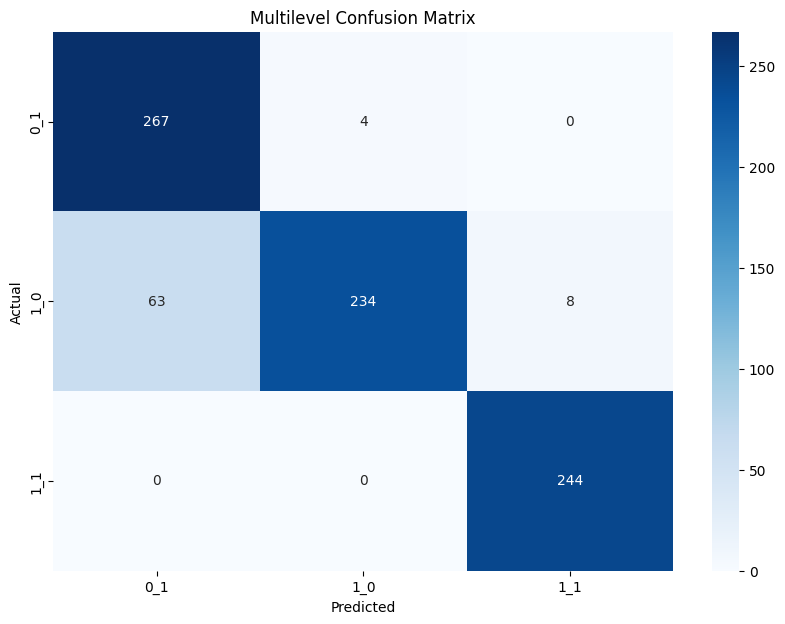

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/content/clintox2 1.csv'
data = pd.read_csv(file_path)

# Display class imbalance
print("Class distribution in FDA_APPROVED and CT_TOX combined:")
print(data[['FDA_APPROVED', 'CT_TOX']].value_counts())

# Handling SMILES column (Feature Extraction Placeholder)
label_encoder = LabelEncoder()
data['smiles_encoded'] = label_encoder.fit_transform(data['smiles'])

# Combine the two target variables into a single multilevel target
data['combined_target'] = data['FDA_APPROVED'].astype(str) + "_" + data['CT_TOX'].astype(str)

# Encode the multilevel target
multilevel_encoder = LabelEncoder()
data['multilevel_encoded'] = multilevel_encoder.fit_transform(data['combined_target'])

# Handle class imbalance for the combined target
classes = data['multilevel_encoded'].unique()
balanced_data = []

for cls in classes:
    class_data = data[data['multilevel_encoded'] == cls]
    if len(class_data) < data['multilevel_encoded'].value_counts().max():
        class_data = resample(class_data, replace=True, n_samples=data['multilevel_encoded'].value_counts().max(), random_state=42)
    balanced_data.append(class_data)

balanced_data = pd.concat(balanced_data)

# Define features and combined target
X = balanced_data[['smiles_encoded']]
y = balanced_data['multilevel_encoded']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize XGBoost classifier
xgboost = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')

# Train the model
xgboost.fit(X_train, y_train)

# Make predictions
y_pred = xgboost.predict(X_test)

# Decode predictions and true labels into original targets
y_test_decoded = multilevel_encoder.inverse_transform(y_test)
y_pred_decoded = multilevel_encoder.inverse_transform(y_pred)

# Evaluate the model
print("Combined Multilevel Confusion Matrix:")
cm = confusion_matrix(y_test_decoded, y_pred_decoded, labels=multilevel_encoder.classes_)
print(cm)

print("Combined Multilevel Classification Report:")
print(classification_report(y_test_decoded, y_pred_decoded, target_names=multilevel_encoder.classes_))

# Plot heatmap for confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=multilevel_encoder.classes_, yticklabels=multilevel_encoder.classes_)
plt.title("Multilevel Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
